# Probability Calibration and PD Modeling
    Making Probabilities Meaningful in Credit Risk
## Objective

This notebook provides a rigorous treatment of probability calibration, covering:

- Why ML probabilities are often miscalibrated

- Difference between ranking and probability accuracy

- Calibration methods used in banking

- PD modeling best practices

- Regulatory and business implications

It answers:

    When a model says “0.23”, does that really mean a 23% chance of default?

## Business Context – Why Calibration Is Mandatory

In Finance & Banking:

- PD feeds Expected Loss = PD × LGD × EAD

- Miscalibrated PDs distort:

    - Capital requirements

    - Pricing

    - Risk appetite

    - Portfolio reporting
- 
> A model can have **excellent AU**C and **terrible PD quality**.

## Imports and Dataset

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("D:/GitHub/Data-Science-Techniques/datasets/Supervised-classification/synthetic_credit_default_classification.csv")

df.head()


,customer_id,age,annual_income,credit_utilization,debt_to_income,loan_amount,loan_term_months,num_past_defaults,employment_years,credit_score,default
0,1,59,23283.682822,0.187813,0.245248,20232.165654,24,0,4.575844,689.627408,1
1,2,49,61262.608063,0.291774,0.396763,26484.067591,36,0,3.317515,697.770541,1
2,3,35,60221.743160,0.230557,0.122859,27142.522594,24,1,11.871955,713.721429,0
3,4,63,93603.112731,0.157906,0.635484,1000.000000,12,0,2.256651,655.306417,1
4,5,28,71674.557271,0.167549,0.422446,15254.246561,48,0,6.971270,644.247643,0


In [2]:
target = "default"

X = df.drop(columns=[target, "customer_id"])
y = df[target]


# Train/Test Split (Stratified)

In [4]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train, X_cal, y_train, y_cal = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    stratify=y_temp,
    random_state=42
)


Result:

- 60% train

- 20% calibration

- 20% test

# MODEL

## Train Base Model (Random Forest)

Random Forest = **strong ranker, weak calibrator.**

### Pipeline

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

base_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        min_samples_leaf=30,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

base_model.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        min_samples_leaf=30, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

## Raw Probability Predictions

In [6]:
y_prob_raw = base_model.predict_proba(X_cal)[:, 1]


## Calibration Diagnostics
### Reliability Curve (Calibration Plot)

In [7]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
    y_cal,
    y_prob_raw,
    n_bins=10,
    strategy="quantile"
)


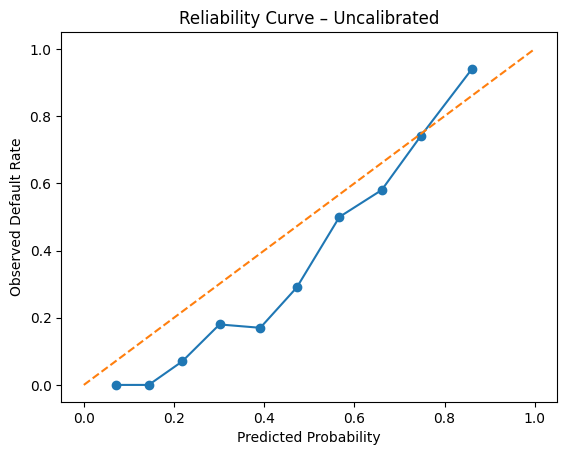

In [8]:
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Default Rate")
plt.title("Reliability Curve – Uncalibrated")
plt.show()


Typical pattern:

- Overconfidence at high scores

- Underconfidence at low scores


## Why Ranking ≠ Calibration

| Concept     | Meaning              |
| ----------- | -------------------- |
| AUC         | Ranking power        |
| Calibration | Probability accuracy |
| KS          | Separation           |
| PD          | Absolute risk        |


AUC can remain unchanged after calibration.



## Calibration Methods
### Platt Scaling (Sigmoid)

- Parametric

- Stable for small datasets

- Common in banking

### Platt Scaling

In [9]:
from sklearn.calibration import CalibratedClassifierCV

platt_calibrated = CalibratedClassifierCV(
    base_model,
    method="sigmoid",
    cv="prefit"
)

platt_calibrated.fit(X_cal, y_cal)


CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('rf',
                                                  RandomForestClassifier(class_weight='balanced',
                                                                         max_depth=8,
                                                                         min_samples_leaf=30,
                                                                         n_estimators=300,
                                                                         n_jobs=-1,
                                                                         random_state=42))]))

## Isotonic Regression

- Non-parametric

- Flexible

- Risk of overfitting

## Isotonic Calibration

In [10]:
iso_calibrated = CalibratedClassifierCV(
    base_model,
    method="isotonic",
    cv="prefit"
)

iso_calibrated.fit(X_cal, y_cal)


CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('rf',
                                                  RandomForestClassifier(class_weight='balanced',
                                                                         max_depth=8,
                                                                         min_samples_leaf=30,
                                                                         n_estimators=300,
                                                                         n_jobs=-1,
                                                                         random_state=42))]),
                       method='isotonic')

## Compare Calibration Quality

In [11]:
prob_raw_test = base_model.predict_proba(X_test)[:, 1]
prob_platt = platt_calibrated.predict_proba(X_test)[:, 1]
prob_iso = iso_calibrated.predict_proba(X_test)[:, 1]


## Reliability Curves (Comparison)

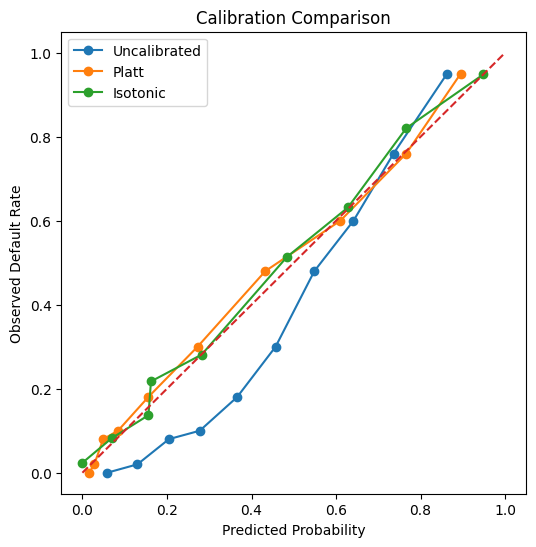

In [12]:
def plot_calibration(y_true, probs, label):
    p_true, p_pred = calibration_curve(
        y_true, probs, n_bins=10, strategy="quantile"
    )
    plt.plot(p_pred, p_true, marker="o", label=label)

plt.figure(figsize=(6, 6))

plot_calibration(y_test, prob_raw_test, "Uncalibrated")
plot_calibration(y_test, prob_platt, "Platt")
plot_calibration(y_test, prob_iso, "Isotonic")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Default Rate")
plt.legend()
plt.title("Calibration Comparison")
plt.show()


## Brier Score (Probability Accuracy)

In [13]:
from sklearn.metrics import brier_score_loss

scores = {
    "Uncalibrated": brier_score_loss(y_test, prob_raw_test),
    "Platt": brier_score_loss(y_test, prob_platt),
    "Isotonic": brier_score_loss(y_test, prob_iso)
}

pd.Series(scores)


Uncalibrated    0.139053
Platt           0.125897
Isotonic        0.126693
dtype: float64

- `[pros] -` Lower is better
- `[pros] -` Proper scoring rule

## PD Modeling Perspective
What Is PD?

PD = **12-month probability of default**

Key requirements:

Monotonicity

- Stability

- Calibration

- Explainability

## PD Bucketing (Risk Grades)

In [21]:
pd_bins = pd.qcut(prob_platt, q=10)

# pd_table = pd.DataFrame({
#     "pd_bucket": pd_bins,
#     "observed_default_rate": y_test.groupby(pd_bins).mean(),
#     "avg_predicted_pd": prob_platt.groupby(pd_bins).mean()
# })

# pd_table


- `[pros - ` Used in scorecards
- `[pros - ` Portfolio reporting
- `[pros - ` Regulatory validation

## Stability Considerations

Calibration must be:

- Monitored over time

- Revalidated under drift

- Recalibrated when necessary

## Common Mistakes (Avoided)

- `[cons] - ` Using raw ML probabilities as PD
- `[cons] - ` Calibrating on test data
- `[cons] - ` Ignoring monotonicity
- `[cons] - ` Overfitting isotonic models
- `[cons] - ` Confusing AUC with PD quality

## Summary Table

| Aspect      | Why It Matters          |
| ----------- | ----------------------- |
| Calibration | Probability correctness |
| Platt       | Stability               |
| Isotonic    | Flexibility             |
| Brier Score | Accuracy                |
| PD Buckets  | Business use            |


## Key Takeaways

- Ranking ≠ probability accuracy

- Calibration is mandatory for PD

- Platt is safer than isotonic

- PDs drive financial decisions

- Governance matters as much as performance

## Next Notebook
04_Supervised_Learning/

└── [06_other_classification_models](06_other_classification_models.ipynb)

<br><br><br><br><br>



# Complete: [Data Science Techniques](https://github.com/lei-soares/Data-Science-Techniques)

- [00_Data_Generation_and_Simulation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/00_Data_Generation_and_Simulation)


- [01_Exploratory_Data_Analysis_(EDA)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/01_Exploratory_Data_Analysis_(EDA))


- [02_Data_Preprocessing](https://github.com/lei-soares/Data-Science-Techniques/tree/main/02_Data_Preprocessing)


- [03_Feature_Engineering](https://github.com/lei-soares/Data-Science-Techniques/tree/main/03_Feature_Engineering)


- [04_Supervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/04_Supervised_Learning)

    - [Regression Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/01_regression_models)
    
    - [Classification Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/02_classification_models)


- [05_Unsupervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/05_Unsupervised_Learning)


- [06_Model_Evaluation_and_Validation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/06_Model_Evaluation_and_Validation)


- [07_Model_Tuning_and_Optimization](https://github.com/lei-soares/Data-Science-Techniques/tree/main/07_Model_Tuning_and_Optimization)


- [08_Interpretability_and_Explainability](https://github.com/lei-soares/Data-Science-Techniques/tree/main/08_Interpretability_and_Explainability)


- [09_Pipelines_and_Workflows](https://github.com/lei-soares/Data-Science-Techniques/tree/main/09_Pipelines_and_Workflows)


- [10_Natural_Language_Processing_(NLP)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/10_Natural_Language_Processing_(NLP))


- [11_Time_Series](https://github.com/lei-soares/Data-Science-Techniques/tree/main/11_Time_Series)


- [12_Anomaly_and_Fraud_Detection](https://github.com/lei-soares/Data-Science-Techniques/tree/main/12_Anomaly_and_Fraud_Detection)


- [13_Imbalanced_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/13_Imbalanced_Learning)


- [14_Deployment_and_Production_Concepts](https://github.com/lei-soares/Data-Science-Techniques/tree/main/14_Deployment_and_Production_Concepts)


- [15_Business_and_Experimental_Design](https://github.com/lei-soares/Data-Science-Techniques/tree/main/15_Business_and_Experimental_Design)




<br><br><br><br><br>

[Panfugo Dados](www.pantufodados.com)


[Pantufo Dados - YouTube Channel](https://www.youtube.com/@pantufodados)